## Prepare input structures

The MOF structures are catagorized into three classes based on the value of $CO_2$ of adsorption heat ($Q_{st}$): DAC, Flue Gas, and General. 

In [1]:
import glob
from dotenv import load_dotenv

import pandas as pd
from ase.io import read
from pathlib import Path

load_dotenv()

files = glob.glob("../structures/*/*.cif")

data = []

class_map = {
    "flue_gas": "Flue Gas",
    "dac": "DAC",
    "general": "General"
}

for file in files:

    row = {
        # "file": file,
        "name": file.split("/")[-1].split(".")[0],
        "class": class_map[file.split("/")[-2]],
        "structure": read(file)
    }
    
    data.append(row)

df = pd.DataFrame(data)
df.to_pickle("input.pkl")
df = pd.read_pickle("input.pkl")

/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'triclinic' is not interpreted for space group Spacegroup(1, setting=1). This may result in wrong setting!
  warnings.warn(
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/ase/io/cif.py:408: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(14, setting=1). This may result in wrong setting!
  warnings.warn(


In [2]:
df

,name,class,structure
0,UTSA-16,Flue Gas,"(Atom('K', [3.226651885197136, 4.3289875091971..."
1,MIL-96(Al),Flue Gas,"(Atom('O', [4.747352350000005, 12.286770663425..."
2,MIL-120,Flue Gas,"(Atom('Al', [3.205338673962497e-05, -9.4470429..."
3,CALF20,Flue Gas,"(Atom('Zn', [-0.24129790834544718, 0.559411884..."
4,MUF-16,Flue Gas,"(Atom('C', [6.197196279188237, 0.0090222, 3.25..."
5,ZnH-MFU-4l,Flue Gas,"(Atom('Zn', [9.759696748000001, 9.759696748000..."
6,Al-PyrMOF,Flue Gas,"(Atom('O', [6.3373961, 2.3106933200000004, 1.4..."
7,ZIF-8,General,"(Atom('Zn', [-2.4522332256501764, 6.9362179409..."
8,HKUST-1,General,"(Atom('Cu', [14.627739280500004, 2.30914745804..."
9,UiO-66,General,"(Atom('C', [17.367786750000004, 2.917324207765..."


## Define flow

In [1]:
from pathlib import Path
import pandas as pd

from ase import Atoms
from ase.build import molecule
from tqdm.auto import tqdm


from mlip_arena.models import MLIPEnum
from mlip_arena.tasks.utils import get_calculator
from mlip_arena.tasks.mof.flow import widom_insertion

from prefect.states import State
from prefect import Task, flow, task
from prefect.client.schemas.objects import TaskRun

import itertools
import functools

@task
def load_row_from_df(fpath: str):
    df = pd.read_pickle(fpath)

    for _, row in df.iterrows():
        yield row

def save_result(
        tsk: Task, run: TaskRun, state: State, 
        row: dict | pd.DataFrame, 
        model_name: str,
        gas: Atoms,
        fpath: Path | str
    ):
    
    result = run.state.result()

    assert isinstance(result, dict)

    copied = row.copy()
    copied["model"] = model_name
    copied["gas"] = gas

    for k, v in result.items():
        copied[k] = v

    fpath = Path(f"{model_name}.pkl")

    if fpath.exists():
        df = pd.read_pickle(fpath)
        df = pd.concat([df, pd.DataFrame([copied])], ignore_index=True)
    else:
        df = pd.DataFrame([copied])

    df.drop_duplicates(subset=["name", "model"], keep='last', inplace=True)
    df.to_pickle(fpath)

@task
def run_one(model_name, gas, row):
    
    result = widom_insertion.with_options(
        on_completion=[functools.partial(
            save_result,
            row=row,
            model_name=model_name,
            gas=gas,
            fpath=f"{model_name}.pkl"
        )]
    )(
        structure=row["structure"],
        gas=gas,
        calculator=get_calculator(
            MLIPEnum[model_name],
            dispersion=True
        ),
        criterion=dict(fmax=0.05, steps=50),
        init_structure_optimize_loops = 10,
    )

    return result


@flow
def run():
    futures = []
    gas = molecule("CO2")

    for model, row in tqdm(itertools.product(MLIPEnum, load_row_from_df('input.pkl'))):

        if model.name not in ['MACE-MPA', 'eqV2(OMat)', 'ORBv2', 'MatterSim']:
            continue
            
        future = run_one(model.name, gas, row)
        futures.append(future)

    
    return [f.result(raise_on_failure=False) for f in futures]

/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
2025-03-13 13:02:35.490 | WARNING  | mlip_arena.models:<module>:34 - No module named 'deepmd'


ModuleNotFoundError: No module named 'mlip_arena.tasks.mof.flow'

In [ ]:
run()

## Run at scale on Slurm cluster

In [2]:

from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from prefect_dask import DaskTaskRunner

# Orchestrate your awesome dask workflow runner

nodes_per_alloc = 1
gpus_per_alloc = 4
ntasks = 1

cluster_kwargs = dict(
    cores=4,
    memory="64 GB",
    shebang="#!/bin/bash",
    account="m3828",
    walltime="00:30:00",
    job_mem="0",
    job_script_prologue=[
        "source ~/.bashrc",
        "module load python",
        "source activate /pscratch/sd/c/cyrusyc/.conda/mlip-arena",
    ],
    job_directives_skip=["-n", "--cpus-per-task", "-J"],
    job_extra_directives=[
        "-J mof",
        "-q regular",
        f"-N {nodes_per_alloc}",
        "-C gpu",
        f"-G {gpus_per_alloc}",
    ],
)

cluster = SLURMCluster(**cluster_kwargs)
print(cluster.job_script())
cluster.adapt(minimum_jobs=10, maximum_jobs=50)
client = Client(cluster)

00:01:59.422 | INFO    | distributed.http.proxy - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy

/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37695 instead
  warnings.warn(


00:01:59.429 | INFO    | distributed.scheduler - State start

00:01:59.432 | INFO    | distributed.diskutils - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-n3f0nfi4', purging

00:01:59.617 | INFO    | distributed.scheduler -   Scheduler at:  tcp://128.55.64.45:39763

00:01:59.622 | INFO    | distributed.scheduler -   dashboard at:  http://128.55.64.45:37695/status

00:01:59.624 | INFO    | distributed.scheduler - Registering Worker plugin shuffle

#!/bin/bash

#SBATCH -A m3828
#SBATCH --mem=0
#SBATCH -t 00:30:00
#SBATCH -J mof
#SBATCH -q regular
#SBATCH -N 1
#SBATCH -C gpu
#SBATCH -G 4
source ~/.bashrc
module load python
source activate /pscratch/sd/c/cyrusyc/.conda/mlip-arena
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/bin/python -m distributed.cli.dask_worker tcp://128.55.64.45:39763 --name dummy-name --nthreads 1 --memory-limit 14.90GiB --nworkers 4 --nanny --death-timeout 60



00:01:59.636 | INFO    | distributed.deploy.adaptive - Adaptive scaling started: minimum=40 maximum=200

00:01:59.649 | INFO    | distributed.scheduler - Receive client connection: Client-9e384796-f73c-11ef-8aa1-dd429e9812e2

00:01:59.651 | INFO    | distributed.core - Starting established connection to tcp://128.55.64.45:43898

In [ ]:
# Run the workflow on HPC cluster in parallel

results = run.with_options(
    task_runner=DaskTaskRunner(address=client.scheduler.address),
    # log_prints=True,
)()

## Plots

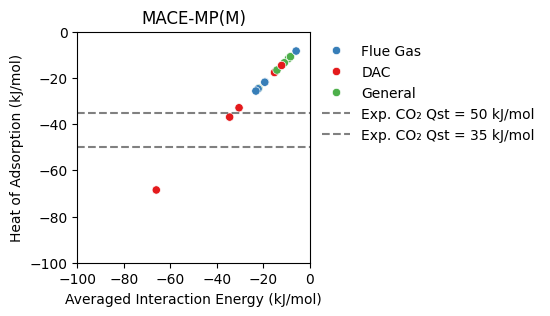

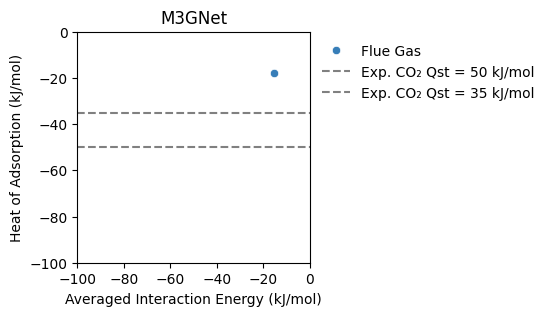

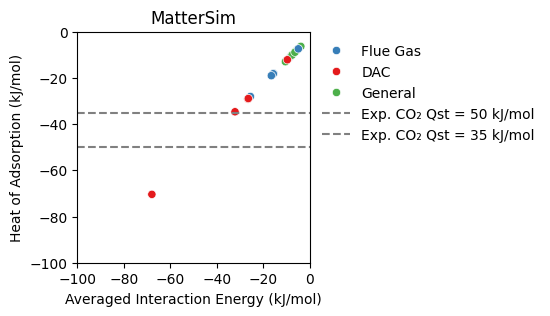

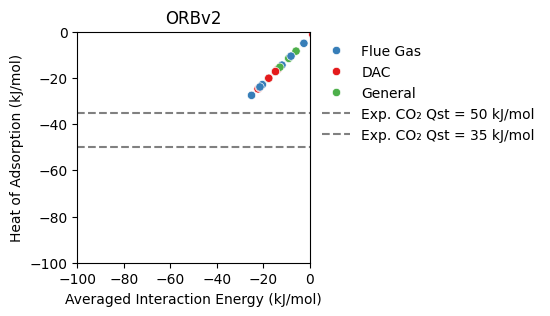

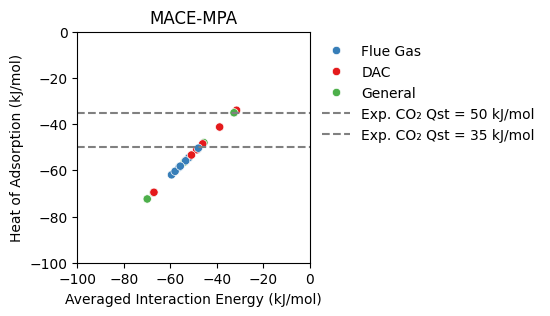

In [4]:
%matplotlib inline

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from ase import units
from pathlib import Path

from mlip_arena.models import MLIPEnum


color_mapping = {
    'DAC': '#e41a1c',                    # e.g., red for DAC
    'Flue Gas': '#377eb8', # e.g., blue
    'General': '#4daf4a'              # e.g., green
}

for model in MLIPEnum:

    fpath = Path(f"{model.name}.pkl")

    if not fpath.exists():
        continue
    
    df = pd.read_pickle(fpath)

    df_exploded = df.explode(['henry_coefficient', 'averaged_interaction_energy', 'heat_of_adsorption'])
    df_group = df_exploded.groupby(['model', 'name', 'class'])[['henry_coefficient', 'averaged_interaction_energy', 'heat_of_adsorption']]
    df = df_group.mean()

    df['averaged_interaction_energy'] = df['averaged_interaction_energy'] * units._e  *  units._Nav * 1e-3 # Convert from eV to kJ/mol

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        data=df,
        x="averaged_interaction_energy",
        y="heat_of_adsorption",
        hue="class",
        palette=color_mapping,
        ax=ax,
    )

    ax.set(
        title=model.name,
        xlim=(-100, 0),
        ylim=(-100, 0),
        xlabel='Averaged Interaction Energy (kJ/mol)',
        ylabel='Heat of Adsorption (kJ/mol)',
    )

    # Add horizontal dashed decision boundaries
    ax.axhline(y=-50, linestyle='--', color='gray', label='Exp. CO₂ Qst = 50 kJ/mol')
    ax.axhline(y=-35, linestyle='--', color='gray', label='Exp. CO₂ Qst = 35 kJ/mol')

    ax.legend(
        # title='Class',
        loc='upper left',
        bbox_to_anchor=(1, 1),
        frameon=False,
    )
    plt.show()
